In [1]:
import numpy as np
import pandas as pd

import confusion_plot
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Imputer

import featuretools as ft

from tpot import TPOTClassifier

# Load and Clean Data

We've done this before!

In [2]:
titanic = pd.read_csv('../../../data/titanic/titanic.csv')
labels = titanic['Survived']
titanic.drop(['Name', 'Survived'], inplace=True, axis=1)

# Automated Feature Engineering

First we build a set of relationships between passengers and their trips, where the passengers are a `parent entity` and the trips are a `child entity`. Operationally, this serves only to tell the algorithm which features to do math on (and recombine).

In [3]:
es = ft.EntitySet(id='passengers')

es = es.entity_from_dataframe(entity_id='passengers', dataframe=titanic, index='PassengerId',
                              variable_types={'Cabin': ft.variable_types.Categorical,
                                              'Embarked': ft.variable_types.Categorical,
                                              'Sex': ft.variable_types.Categorical})

es = es.normalize_entity(base_entity_id='passengers',
                         new_entity_id='trip',
                         index='Ticket',
                         additional_variables=['Fare', 'Embarked', 'Pclass', 'Cabin'])

Next, we tell FeatureTools how to build secondary features and crossterms:

In [4]:
feature_matrix, feature_defs = ft.dfs(entityset=es,
                                        target_entity='passengers',
                                        agg_primitives=["mean", "sum", "mode"],
                                        max_depth=3)

Now we one-hot encode the feature vectors and display. Note here, that this is a wildly simple application for autoFE. This is an example for a more realistic case, where we'd have one-to-many relationships between entities and features.

In [5]:
feature_matrix_enc, features_enc = ft.encode_features(feature_matrix, feature_defs)

with pd.option_context('display.max_columns', None):
    display(feature_matrix_enc.head())

,Age,Parch,SibSp,Ticket = CA. 2343,Ticket = CA 2144,Ticket = 1601,Ticket = S.O.C. 14879,Ticket = PC 17608,Ticket = 347082,Ticket = 347077,Ticket = 3101295,Ticket = 382652,Ticket = 347088,Ticket = unknown,Sex = male,Sex = female,Sex = unknown,trip.Fare,trip.Embarked = S,trip.Embarked = C,trip.Embarked = Q,trip.Embarked = unknown,trip.Pclass,trip.Cabin = B57 B59 B63 B66,trip.Cabin = C23 C25 C27,trip.Cabin = C22 C26,trip.Cabin = G6,trip.Cabin = E34,trip.Cabin = C82,trip.Cabin = C78,trip.Cabin = F4,trip.Cabin = F33,trip.Cabin = F2,trip.Cabin = unknown,trip.MEAN(passengers.Age),trip.MEAN(passengers.Parch),trip.MEAN(passengers.SibSp),trip.SUM(passengers.Age),trip.SUM(passengers.Parch),trip.SUM(passengers.SibSp),trip.MODE(passengers.Sex) = male,trip.MODE(passengers.Sex) = female,trip.MODE(passengers.Sex) = unknown
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,22.0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,7.2500,1,0,0,0,3,0,0,0,0,0,0,0,0,0,0,1,22.0,0.0,1.0,22.0,0,1,1,0,0
2,38.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,71.2833,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,38.5,0.0,1.0,77.0,0,2,0,1,0
3,26.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,7.9250,1,0,0,0,3,0,0,0,0,0,0,0,0,0,0,1,26.0,0.0,0.0,26.0,0,0,0,1,0
4,35.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,53.1000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,36.0,0.0,1.0,72.0,0,2,0,1,0
5,35.0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,8.0500,1,0,0,0,3,0,0,0,0,0,0,0,0,0,0,1,35.0,0.0,0.0,35.0,0,0,1,0,0


# Impute Missing Values

We've done this before!

In [6]:
feature_matrix_enc.fillna('NaN')
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
X = imp.fit_transform(feature_matrix_enc.values)

# Train/Validate Split

In [7]:
y = labels.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# Automated Modeling

In [11]:
%%time

tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2, n_jobs=-1)
tpot.fit(X_train, y_train)

Optimization Progress:  33%|███▎      | 40/120 [00:13<02:13,  1.67s/pipeline]

Generation 1 - Current best internal CV score: 0.8709154277002013


Optimization Progress:  50%|█████     | 60/120 [00:24<01:18,  1.30s/pipeline]

Generation 2 - Current best internal CV score: 0.8709369431878526


Optimization Progress:  67%|██████▋   | 80/120 [00:34<01:22,  2.07s/pipeline]

Generation 3 - Current best internal CV score: 0.8709369431878526


Optimization Progress:  83%|████████▎ | 100/120 [00:49<00:54,  2.74s/pipeline]

Generation 4 - Current best internal CV score: 0.8726175553597757


Generation 5 - Current best internal CV score: 0.8726175553597757

Best pipeline: RandomForestClassifier(PolynomialFeatures(ZeroCount(input_matrix), degree=2, include_bias=False, interaction_only=False), bootstrap=True, criterion=gini, max_features=0.6000000000000001, min_samples_leaf=16, min_samples_split=11, n_estimators=100)
CPU times: user 9.39 s, sys: 445 ms, total: 9.83 s
Wall time: 1min 36s


# Calculate Accuracy

In [9]:
preds = tpot.predict(X_test)

accuracy_score(preds, y_test)

0.8320610687022901

Normalized confusion matrix
[[0.87671233 0.12328767]
 [0.22413793 0.77586207]]


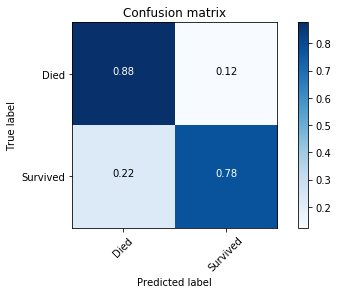

In [10]:
conf = confusion_matrix(y_test, preds)

confusion_plot.plot_confusion_matrix(conf, classes=['Died', 'Survived'], normalize=True)